Notes
- Try lag
- Try standardizing outpot to fit in hypotangent
- Maybe remove 0s
- Change learning rate for re-training
- Restandardization

In [1]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras import optimizers 
import tensorflow as tf

ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/github/'
# ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/jupyteruser/31170133/github/'
os.chdir(ts_dir)

def mse(y, yhat):
    return np.mean( (y - yhat)**2 ) 


In [2]:
from tensorflow.keras.utils import Sequence

# credits to https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
class Generator(Sequence):
    'Generates data in batches for Keras'
    
    def __init__(self, X, y, batch_size = 1, shuffle = True):
        'Initialization'
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Gives number of batches per poch, |_len(y)/batch_size_|'
        return int(np.floor(len(self.y)/self.batch_size))
    
    def __getitem__(self, index):
        'returns a single batch'
        return self.__data_generation(index)
    
    def on_epoch_end(self):
        'Shuffles indices after each epoch'
        self.indices = np.arange(len(self.y)) # possible indices
        if self.shuffle:
            np.random.shuffle(self.indices) # shuffle the indices 
            
    def __data_generation(self, index):
        'generate data'
        
        Xbatch = self.X[index].reshape(1, *self.X[index].shape)
        ybatch = self.y[index].reshape(1, *self.y[index].shape)
        return Xbatch, ybatch


#### Data prep

In [3]:
## Only run if us_mobility.csv hasn't been created or needs updating 

# global_mob = pd.read_csv('../Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('data/us_mobility.csv', index = False)

In [4]:
## Read in Mobility

mob = pd.read_csv('data/us_mobility.csv')
mob['county'] = mob['county'].str.replace(' Parish', '')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()


,state,county,date,retail,grocery,parks,transit,work,residential
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [5]:
## Read in Counts

nyt = pd.read_csv(f'data/us-counties.csv').drop(columns = 'fips')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [6]:
## Merge mobility and counts 

mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [7]:
## Add in populations (when possible)

pop = pd.read_csv('data/pop.csv')
mob = pd.merge(mob, pop, on = ['state','county'], how = 'left')


In [8]:
## Add in miscellaneous stuff

# County ID
mob['ID'] = mob.groupby(['state','county']).ngroup() # assign each county an ID
# Days
first_day = mob.date.min()
mob['days_in'] = (mob['date'] - first_day).apply(lambda date: date.days)
# Per Capita
mob['casespc'] = 100000*mob['cases']/mob['pop'] # cases per 100k
mob['logcasespc'] = np.log(1 + mob['casespc']) # log(1 + casespc)
# Lags
mob['diffcounty'] = (mob['county'] != mob['county'].shift(1)) # binary for whether its a different county than the one before
mob['new'] = mob['cases'] - mob['cases'].shift(1)
mob.loc[mob['diffcounty'] == True, 'new'] = np.nan
mob.loc[mob['new'] < 0, 'new'] = 0 # check this
mob.loc[mob['date'] == mob['date'].min(), 'new'] = 0 # set equal to 0 for first day
mob['newpc'] = 100000*mob['new']/mob['pop'] # new per 100k
mob['lognewpc'] = np.log(1 + mob['newpc'])

In [9]:
## Decide whether to keep counties and columns based on response rates

# pick columns
cats = ['grocery','retail','work'] # note: only use these categories for building PCs
fullcats = ['grocery','parks','residential','retail','transit','work'] # other categories
mob.drop(columns = [col for col in fullcats if col not in cats], inplace = True)

# pick rows/counties
missingrates = mob.groupby(['state','county','ID'])[cats].agg(lambda x: np.mean(pd.isnull(x))).reset_index() # missing rates by column for cats
allowance = 0.35 # what percent you're allowed to have missing without getting cut (check distplots of missingrates for reasonable cutoff)
keeper_IDs = missingrates.loc[(missingrates[cats] < allowance).sum(1) == 3, 'ID'].values # IDs of counties with all 3 under allowance
mob = mob[mob['ID'].isin(keeper_IDs)] # only keep those ones
mob.fillna(mob.groupby(['ID','state','county'])[cats].transform('median'), inplace = True) # fill in with median for group
mob = mob.loc[mob.groupby('ID')['casespc'].transform(lambda x: np.mean(pd.isnull(x))) == 0] # remove counties with missing cases pc ## CULPRIT 
mob.reset_index(inplace = True, drop = True)


#### Model!

In [10]:
class DynamicLSTM():

    def __init__(self, name):
        '''Initialization'''
        self.name = name
        
    def get_data(self, mob = None, train_standardization = False, end_train = None, cats = None, target = None, nahead = None, valfrac = None, generator = None):
        '''Get X and y'''
        if not cats is None:
            self.cats = cats
        if not target is None:
            self.target = target
            self.predictors = self.cats + [self.target]
        if not mob is None:
            self.mob = mob
            self.preds = mob[['state','county','ID','date', self.target]].copy()            
        if not nahead is None:
            self.nahead = nahead
        if not valfrac is None:
            self.valfrac = valfrac
        if not generator is None:
            self.generator = generator 
        
        # Standardize
        if train_standardization:
            self.ss = SS().fit(mob.loc[mob['date'] <= end_train, self.cats]) 
        mobstand = self.ss.transform(mob[self.cats])
        mob[self.cats] = pd.DataFrame(mobstand, columns = self.cats, index = mob.index)
        
        # Select training
        mobtrain = mob[mob['date'] <= end_train]
        self.mobtrain = mobtrain
        
        # Make X and y
        grouped = self.mobtrain[['state','county','ID'] + self.predictors].groupby(['state','county','ID'])
        X = []
        y = []
        for (state, county, ID), data in grouped:
            X.append(np.array(data[self.predictors].iloc[:-self.nahead]))
            y.append(np.array(data[self.target].iloc[-1])) 
        X = np.array(X)
        y = np.array(y)
        nsamples = len(y)
            
        # Train/Validation Split
        np.random.seed(109)
        val_indices = np.random.choice(np.arange(nsamples), int(self.valfrac*nsamples), replace = False)
        self.Xval = X[val_indices]
        self.yval = y[val_indices]
        self.Xtrain = np.delete(X, val_indices, axis = 0)
        self.ytrain = np.delete(y, val_indices, axis = 0)
        self.train_generator = self.generator(self.Xtrain, self.ytrain)
        self.val_generator = self.generator(self.Xval, self.yval)

        
    def build(self, output_shape = 1, nunits = 500, interunits = 100, droprate = 0.15, optimizer = 'adam', summary = True):
        '''Build Model'''
        inputs = Input(shape = (None, len(self.predictors)), name = 'inputs')
        layer = LSTM(units = nunits, name = 'lstm1', activation = 'tanh')(inputs)
        layer = Dropout(rate = droprate, name = 'drop1')(layer)
        layer = Dense(interunits, activation = 'relu', name = 'inters')(layer)
        outputs = Dense(output_shape, activation = 'relu', name = 'outputs')(layer)
        mod = Model(inputs, outputs, name = 'mod')
        mod.compile(optimizer, loss = 'mean_squared_error')
        self.mod = mod
        if summary:
            print(mod.summary())
        
    def fit(self, epochs, callbacks, verbose):
        '''Initial Fit'''
        self.history = self.mod.fit_generator(self.train_generator,
                                        validation_data = self.val_generator,
                                        epochs = epochs,
                                        verbose = verbose,
                                        callbacks = callbacks)
        
    def update(self, epochs, callbacks, verbose):
        '''Update fit'''
        self.update_history = self.mod.fit_generator(self.train_generator,
                                                    validation_data = self.val_generator,
                                                    epochs = epochs,
                                                    verbose = verbose,
                                                    callbacks = callbacks)
    def predict(self, test_date, generator):
        '''predictions'''
        
        # Standardize
        self.mobtest = self.mob[self.mob['date'] <= test_date].copy()
        mobteststand = self.ss.transform(self.mobtest[self.cats])
        self.mobtest[self.cats] = pd.DataFrame(mobteststand, columns = self.cats, index = self.mobtest.index)
                
        # Make Xtest and ytest
        grouped = self.mobtest[['state','county','ID'] + self.predictors].groupby(['state','county','ID'])
        Xtest = []
        ytest = []
        for (state, county, ID), data in grouped:
            Xtest.append(np.array(data[self.predictors].iloc[:-nahead]))
            ytest.append(np.array(data[self.target].iloc[-1])) 
        self.Xtest = np.array(Xtest)
        self.ytest = np.array(ytest)
        self.test_generator = generator(self.Xtest, self.ytest)
        
        # Predict
        self.fitted = self.mod.predict_generator(self.test_generator)
        
        # Add to dataframe
        newpreds = pd.DataFrame(np.array(list(grouped.groups.keys())), columns = ['state','county','ID'])
        newpreds['ID'] = newpreds['ID'].astype('int64')
        newpreds['fitted'] = self.fitted # add fitted values 
        newpreds['date'] = self.mobtest.date.max() # date is most recent date
        self.newpreds = newpreds
        self.preds = self.preds.merge(newpreds, how = 'left', on = ['state','county','ID','date']) # merge with preds

    def get_dates(self):
        self.train_date = self.mobtrain.date.max()
        self.test_date = self.mobtest.date.max()
        
    def savemod(self, filename):
        self.mod.save(f'models/{filename}.h5')  
    def loadmod(self, filename):
        self.mod = load_model(f'models/{filename}.h5')
    

In [14]:
## Instantiate        
lstm = DynamicLSTM('name')

## Get Data
# date stuff
dates = mob.date.unique()
ndates = len(dates)
end_first_train = dates[int(0.7*ndates)]
end_train = end_first_train.copy()
# target, nahead
target = 'logcasespc'
nahead = 3
predictors = cats + [target]
# other parameters
train_standardization = True
valfrac = 0.1
# get data!
lstm.get_data(mob, train_standardization, end_train, cats, target, nahead, valfrac, Generator)

## Build
nunits = 500
interunits = 100
droprate = 0.15
lr0 = 0.00003
optimizer = optimizers.Adam(lr0)
lstm.build(nunits = nunits, interunits = interunits, droprate = droprate, optimizer = optimizer)


Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 4)]         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 500)               1010000   
_________________________________________________________________
drop1 (Dropout)              (None, 500)               0         
_________________________________________________________________
inters (Dense)               (None, 100)               50100     
_________________________________________________________________
outputs (Dense)              (None, 1)                 101       
Total params: 1,060,201
Trainable params: 1,060,201
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.7636 - val_loss: 0.3436
Epoch 2/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.3054 - val_loss: 0.3193
Epoch 3/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2660 - val_loss: 0.2807
Epoch 4/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2460 - val_loss: 0.2641
Epoch 5/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2314 - val_loss: 0.2413
Epoch 6/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2216 - val_loss: 0.2392
Epoch 7/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2181 - val_loss: 0.2263
Epoch 8/20
1836/1836 [==============================] - 52s 29ms/step - loss: 0.2075 - val_loss: 0.2505
Epoch 9/20
1836/1836 [==============================] - 53s 29ms/step - loss: 0.2122 - val_loss: 0.2321
Epoch 10/20
1836/1836 [==============================] - 53s 29m

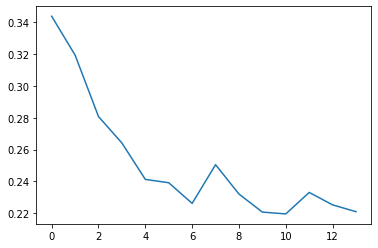

In [15]:
## Fit
epochs = 20
dr = 0.002
lr_schedule = LearningRateScheduler(lambda epoch, lr0 = lr0, dr = dr: lr0*np.exp(-dr*epoch))
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
callbacks = [early_stopping, lr_schedule]
verbose = 1
lstm.fit(epochs, callbacks, verbose)
sns.lineplot(range(len(lstm.history.history['val_loss'])), lstm.history.history['val_loss']);
# lstm.savemod('dynamic')

## Or load
# lstm.loadmod('dynamic')

# Predict
test_date = end_train + np.timedelta64(nahead, 'D')
lstm.predict(test_date, Generator)

# Get MSE
ytesthat = lstm.fitted.reshape(-1)
ytest = lstm.ytest.reshape(-1)
mse_ = mse(ytest, ytesthat)
print('MSE:', mse_)
assert(mse_ < 0.35), 'MSE too high!'



In [ ]:
last_date = mob.date.max() - np.timedelta64(nahead, 'D') # go until here
end_train = end_first_train
while end_train <  last_date:
    # Turn off standardization, get new date
    train_standardization = False # don't want to re-train standardization
    end_train = end_train + np.timedelta64(1, 'D')

    # Get data
    lstm.get_data(mob, train_standardization, end_train)

    # Update
    epochs = 4
    callbacks = [early_stopping, lr_schedule]
    verbose = 1
    lstm.update(epochs, callbacks, verbose)

    # Predict
    test_date = end_train + np.timedelta64(nahead, 'D')
    lstm.predict(test_date, Generator)

    # get MSE
    ytesthat = lstm.fitted.reshape(-1)
    ytest = lstm.ytest.reshape(-1)
    print('MSE:', mse(ytest, ytesthat))
    
    # plot
    sns.scatterplot(ytest, ytesthat)
    plt.show()

Epoch 1/4
1836/1836 [==============================] - 53s 29ms/step - loss: 0.1797 - val_loss: 0.1740
Epoch 2/4
 405/1836 [=====>........................] - ETA: 39s - loss: 0.1860

In [ ]:
lstm.savemod('dynamic')
preds = lstm.preds
preds.to_csv('models/preds.csv', index = False)

___

In [ ]:
# Get County 
county = 'Miami-Dade'
state = 'Florida'
mobCounty = mob[(mob['county'] == county) & (mob['state'] == state)].copy()
# standardize cats
mobCounty[cats] = lstm.ss.transform(mobCounty[cats])
# group
groupedCounty = mobCounty[['state','county','ID'] + ['date'] + predictors].groupby(['state','county','ID'])
# get X and y
XCounty = []
yCounty = []
test_dates = mobCounty['date'][mobCounty['date'] >= start_test]
for date in test_dates:
    mobCountyToDate= mobCounty[mobCounty['date'] <= date]
    XCounty.append(np.array(mobCountyToDate[predictors].iloc[:-nahead]))
    yCounty.append(np.array(mobCountyToDate[target].iloc[-1]))
XCounty = np.array(XCounty)
yCounty = np.array(yCounty)
# Get generator
CountyGenerator = Generator(XCounty, yCounty)
# Get fitted values 
yCountyHat = lstm.mod.predict_generator(CountyGenerator).reshape(-1)
# Plot
fig = sns.lineplot(range(len(yCounty)), yCounty, label = 'observed')
fig = sns.lineplot(range(len(yCounty)), yCountyHat, label = 'fitted')
fig.set(title = f'Fitted and Observed for {county} County, {state} (Logged)');

In [ ]:
fig = sns.lineplot(range(len(yCounty)), np.exp(yCounty) - 1, label = 'observed')
fig = sns.lineplot(range(len(yCounty)), np.exp(yCountyHat) - 1, label = 'fitted')
fig.set(title = f'Fitted and Observed for {county} County, {state} (Unlogged)');